In [ ]:
import os
import re
import cv2
import time
import shutil
import zipfile
import urllib.request
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
from random import randrange
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [ ]:
training_data_processor = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1
)

test_data_processor = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_data_dir = '/content/drive/MyDrive/Soil_Dataset/Train'
test_data_dir = '/content/drive/MyDrive/Soil_Dataset/Test'

In [ ]:
training_data = training_data_processor.flow_from_directory(
    train_data_dir,
    target_size=(150,150), 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=True
)

testing_data = test_data_processor.flow_from_directory(
    test_data_dir,
    target_size=(150,150), 
    class_mode='categorical', 
    batch_size=64, 
    shuffle=False
)

Found 715 images belonging to 4 classes.
Found 188 images belonging to 4 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 73984)             0

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
start = time.time()

simple_history = model.fit(training_data, epochs=20, validation_data = testing_data)
end = time.time()
print("Total train time: ",(end-start)/60," mins")

Epoch 1/20
12/12 [==============================] - 258s 21s/step - loss: 2.1419 - accuracy: 0.3105 - val_loss: 1.0039 - val_accuracy: 0.4894
Epoch 2/20
12/12 [==============================] - 6s 536ms/step - loss: 0.7048 - accuracy: 0.7063 - val_loss: 0.4858 - val_accuracy: 0.7766
Epoch 3/20
12/12 [==============================] - 7s 628ms/step - loss: 0.4101 - accuracy: 0.8252 - val_loss: 0.7180 - val_accuracy: 0.7660
Epoch 4/20
12/12 [==============================] - 6s 515ms/step - loss: 0.3176 - accuracy: 0.8545 - val_loss: 0.3672 - val_accuracy: 0.8351
Epoch 5/20
12/12 [==============================] - 7s 611ms/step - loss: 0.2871 - accuracy: 0.8713 - val_loss: 0.7063 - val_accuracy: 0.7394
Epoch 6/20
12/12 [==============================] - 6s 520ms/step - loss: 0.2246 - accuracy: 0.9049 - val_loss: 0.4130 - val_accuracy: 0.8511
Epoch 7/20
12/12 [==============================] - 7s 616ms/step - loss: 0.2165 - accuracy: 0.9175 - val_loss: 0.6967 - val_accuracy: 0.8085
Epoch 

In [ ]:
score = model.evaluate_generator(testing_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<ipython-input-10-0555d712d68d>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(testing_data)


Test loss: 0.34376809000968933
Test accuracy: 0.9308510422706604


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
num_of_test_samples = 188 
Y_pred = model.predict_generator(testing_data, num_of_test_samples) 
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testing_data.classes, y_pred)
print('Confusion Matrix')
print(simple_cm)
print('Classification Report')
target_names = ['Alluvial_Soil', 'Black_Soil', 'Clay_Soil', 'Red_Soil']
print(classification_report(testing_data.classes, y_pred, target_names=target_names))

<ipython-input-13-3373f0b20c27>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(testing_data, num_of_test_samples)


Confusion Matrix
[[40  1  6  1]
 [ 3 42  2  0]
 [ 0  0 47  0]
 [ 0  0  0 46]]
Classification Report
               precision    recall  f1-score   support

Alluvial_Soil       0.93      0.83      0.88        48
   Black_Soil       0.98      0.89      0.93        47
    Clay_Soil       0.85      1.00      0.92        47
     Red_Soil       0.98      1.00      0.99        46

     accuracy                           0.93       188
    macro avg       0.94      0.93      0.93       188
 weighted avg       0.93      0.93      0.93       188



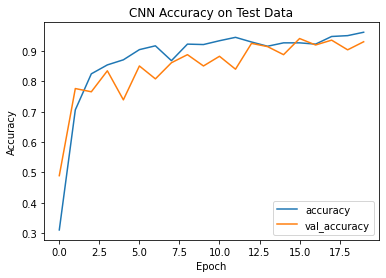

In [ ]:
plt.plot(simple_history.history["accuracy"])
plt.plot(simple_history.history['val_accuracy'])
plt.title("CNN Accuracy on Test Data")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["accuracy","val_accuracy"], loc='lower right')
plt.show()

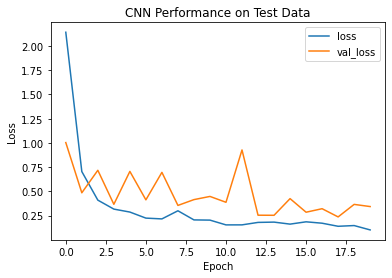

In [ ]:
plt.plot(simple_history.history["loss"])
plt.plot(simple_history.history['val_loss'])
plt.title("CNN Performance on Test Data")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","val_loss"], loc='upper right')
plt.show()

In [ ]:
MODEL_NAME = 'soil'
model.save(f'{MODEL_NAME}.h5')